<a href="https://colab.research.google.com/github/vasishtahd/Twitter-Bot-Detection-With-Graph-Analytics/blob/master/initial_retweeter_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CSE 573: Semantic Web Mining**

![Google's logo](https://fys.asu.edu/sites/default/files/styles/panopoly_image_original/public/asu_logo_1.png?itok=pBT1SdKj)


Spring 2020

Group 4 - Project 6

Detection Of Fake Twitter Bots Through Unsupervised Learning

Members:
* Aditya Narayanan (1215232278)
* Vasishta Harekal (1215278298)
* Sumukh Ashwin Kamath (1217723013)
* Renu Kadolkar (1215200727)
* Hang Zhao (1214868408)
* Cheng Chen (1216700771)
* Shankar Krishnamoorthy (1217214947)

In [0]:

from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from collections import Counter
from time import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection, neighbors)
import collections

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
format_timestamp = '%Y-%m-%d %H:%M:%S'
bin_width = 120
bins_list = list(range(0, 3601, bin_width))
no_of_clusters=5
scaler = MinMaxScaler()

PROJECT_ROOT = "/content/drive/Shared drives/SWM/SWM_data/"
time_sorted_tweet_data = pd.read_csv("/content/drive/Shared drives/SWM/timeSortedDataset.csv", lineterminator='\n')
start_time = time_sorted_tweet_data['postedEpochtime'].values[0]
drive.mount('/content/drive')
botnames_list,bot_name_dict=[],{}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
 def bot_list_prep():
   '''Prepares the list of bots in a dict'''
   botnames = pd.read_csv("/content/drive/Shared drives/SWM/botnames.csv", lineterminator='\n')
   botnames_list=botnames['BotName'].tolist()
   print("Total Bots:",len(botnames_list))
   bot_name_dict={}
   for bot in botnames_list:
      bot_name_dict[bot]=1
   return botnames_list,bot_name_dict
   
# 
def convertToEpoch(date_string):
    '''Function to convert to epoch time ''' 
    date= dt.strptime(date_string, format_timestamp)
    epoch_time = int(date.timestamp())
    return epoch_time

# 
def extract_inter_posting_time_density(timestamp):
    '''Extract the inter posting time density''' 
    if len(timestamp) <= 1:
        diff_ts = np.array([])
    else:
        diff_ts = np.diff(timestamp)
    diff_bins = diff_ts[diff_ts < 4000]
    return np.histogram(diff_bins, bins=bins_list)[0]

#
def get_post_counts_of_bots(threshold=0):
    '''returns a dictionary with retweet counts for each bot from botnames.csv'''
    botnames, botnames_dict = bot_list_prep()
    tweets_screen_name_counts = collections.Counter(time_sorted_tweet_data['screen_name_from'].tolist())
    bots_intersection = set(botnames).intersection(set(tweets_screen_name_counts.keys()))
    post_count = collections.defaultdict(int)
    for bot in bots_intersection:
        tweets_bot_count = tweets_screen_name_counts[bot]
        if tweets_bot_count >= threshold:
            post_count[bot] = tweets_bot_count
    return {k:v for k,v in sorted(post_count.items(), key=lambda item: item[1], reverse=True) }

In [0]:
def plotTSNE(features_np):
  '''Plot T-Squared NE''' 
  time_start =  time()
  tsne =  manifold.TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
  tsne_results = tsne.fit_transform(features_np )
  print('t-SNE done! Time elapsed: {} seconds'.format(time()-time_start))
  return tsne_results

In [0]:
def scatterPlotTSNE(tsne_results, clusterLabels):
  '''Scatter Plot T-Squared NE''' 
  df_subset= pd.DataFrame()
  df_subset['tsne-2d-one'] = tsne_results[:,0]
  df_subset['tsne-2d-two'] = tsne_results[:,1]
  df_subset['y'] = clusterLabels
  plt.figure(figsize=(16,10))
  sns.scatterplot(
      x="tsne-2d-one", y="tsne-2d-two",
      hue="y",
      palette=sns.color_palette('coolwarm', n_colors=5), 
      data=df_subset,
      legend="full",
      alpha=0.3
  )

In [0]:
def compute_features_all_users(tweet_data_grp_by_user):
      '''Compute Inter Posting Time Density Features for all users''' 
      count = 0

      users = []
      features = []
      for item in tweet_data_grp_by_user.iteritems():
          if(len( item[1])>1):
              users.append(item[0])
              inter_post_density=np.array(extract_inter_posting_time_density(item[1]))
            
              features.append(inter_post_density)
          count += 1
      return users,features

In [0]:
def get_user_grouped_data(tweet_data):
    ''' Get User Grouped Data Based on Posted Epoch Time'''
    # Converting the postedtime to epoch and Adding it as a column in the dataframe
    posted_time_np = tweet_data['postedtime'].to_numpy()
    posted_epoch_time = np.array(list(map(convertToEpoch, posted_time_np)))
    tweet_data["postedEpochtime"] = posted_epoch_time
    # Sorting the dataframe by postedEpochtime and group by user
    tweet_data_grp_by_user = tweet_data.sort_values('postedEpochtime').groupby("screen_name_from")["postedEpochtime"].apply(list)
    return tweet_data_grp_by_user

In [0]:
def cluster_data(features_np,botnames_list):
    '''Perform k-means Cluster Analysis on User Features'''
    features_np=scaler.fit_transform(features_np)
    clustering = KMeans(n_clusters=no_of_clusters,random_state=0,init='k-means++').fit(features_np)
    print(clustering.labels_)
    np.unique(clustering.labels_  ,return_counts=True)
     
    bot_name_dict={}

    with open('kmeans.txt', 'w') as f:
        for i in range(len(clustering.labels_)):
            f.write("%s\n" % clustering.labels_[i])

    return clustering

In [0]:
def count_cluster_members(clustering ):
    ''' Count Cluster Members based on Labels '''
    c = Counter(clustering.labels_)
    return c


def count_cluster_bots(clustering,bot_name_dict,users):
    ''' For each cluster count the number of bots ''' 
    cluster_membership={str(i):[] for i in range(no_of_clusters)}        
    for i in range(len(clustering.labels_)):
            
            if users[i] in bot_name_dict:
                cluster_membership[str(clustering.labels_[i])].append(users[i])

    sorted_dict = collections.OrderedDict(cluster_membership)
    
    return sorted_dict

In [0]:
def plot_cluster_membership(users,features_np,clustering,botnames_list,no_of_clusters=5 ):
    ''' Plot Cluster Membership for User and Features ''' 
    user_arr = np.array(users)
    dataset = pd.DataFrame({'user': user_arr, 'features_np': list(features_np)}, columns=['user', 'features_np'])
    dataset["clusterMembership"]=clustering.labels_
    dataset["isBot"]=0
 
    dataset.loc[dataset['user'].isin(botnames_list),"isBot"] =1

    funcList=[np.sum,np.mean]
    
    for cluster in range(no_of_clusters):     
        for types in {0,1}:
            
                    subset=dataset[(dataset["isBot"]==types) & (dataset["clusterMembership"]==cluster) ]
                    features_list=subset["features_np"].tolist() 
                    if(len(features_list)<1):
                        continue
                    print(cluster, types, len(features_list),len(features_list[0]))
                   
                    array_result = np.mean(features_list,axis=0)
                    result=array_result
                    df = pd.DataFrame({'Feature':result}, index= [i for i in range(len(result))])
                    ax = df.plot.bar(rot=0,figsize=(10,5))
                    title=str("Cluster:"+str(cluster)+" Bot or Not:"+str(types)+ " Count:"+str(len(features_list)))
                    ax.set_title( title)                     
                    fig = ax.get_figure()     
                    file_name="Cluster_"+str(cluster)+"_Bot_"+str(types)
                    fig.savefig('plot_results\\'+file_name+'.jpg')
                    print("\r" + str("Cluster:"+str(cluster)+" | Bot or Not:"+str(types)+" Result:"), end="")

# Run from this section


# Run Clustering

In [0]:
botnames_list,bot_name_dict=bot_list_prep()
tweet_data_grp_by_user=get_user_grouped_data(tweet_data)
users,features=compute_features_all_users(tweet_data_grp_by_user)
features_np = np.array(features)
print("\nFeature Matrix:\n",features_np)
print("\nClustering:")
clustering=cluster_data(features_np,botnames_list)
print(clustering)
print("\nCluster Membership Count:\n\n")
c=count_cluster_members(clustering )
sorted_bot_in_cluster_dict=count_cluster_bots(clustering,bot_name_dict,users)
print("\nTotal Cluster:\n,c)
print("Sorted_bot_in_cluster_dict:\n", sorted_bot_in_cluster_dict)


Total Bots: 8087
Feature Matrix:
 [[1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [3 1 4 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Clustering:
[0 0 0 ... 0 0 0]
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)
Cluster Membership Count:

Total Cluster:
 Counter({0: 251852, 3: 11388, 1: 3275, 2: 960, 4: 960})
Sorted_bot_in_cluster_dict:
 OrderedDict([('0', ['AAOLion', 'AGuyUpNorth', 'AceDailyNews', 'AkuraElvas', 'AmandeepBhogal', 'AndyCarp18', 'Archieb48709437', 'Binarymap', 'BreatheLove75', 'CatoTheYounger4', 'CharleyBravoUK', 'CittadinaJ', 'Clavelina18', 'CllrDDutton', 'ColetteParson17', 'ColloquySussex', 'CreativeDeduct', 'DOVEBRICK', 'DarrenPlymouth', 'Davcol1', 'DavidTheCaver', 'DenaSanger', 'DontDenyThe', 'DoomBarNone', 'Ella1898', 'EpoxyG7', 'EthicsRetweet', 'Fjodor10187991', 'GRIMESPIRIT', 'GameChangerGirl', 'Gareth195

# Cluster Membership Visualisation

0 0 251694 30
Cluster:0 | Bot or Not:0 Result:0 1 158 30
Cluster:0 | Bot or Not:1 Result:1 0 3100 30
Cluster:1 | Bot or Not:0 Result:1 1 175 30
Cluster:1 | Bot or Not:1 Result:2 0 830 30
Cluster:2 | Bot or Not:0 Result:2 1 130 30
Cluster:2 | Bot or Not:1 Result:3 0 11266 30
Cluster:3 | Bot or Not:0 Result:3 1 122 30
Cluster:3 | Bot or Not:1 Result:4 0 953 30
Cluster:4 | Bot or Not:0 Result:4 1 7 30
Cluster:4 | Bot or Not:1 Result:

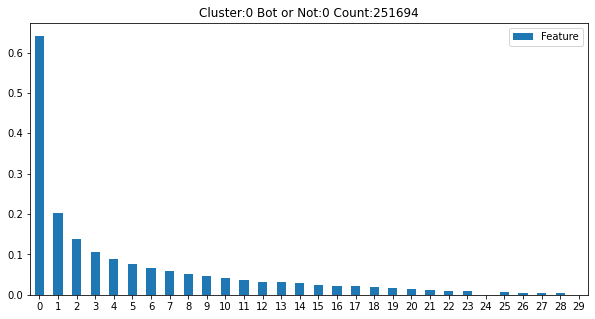

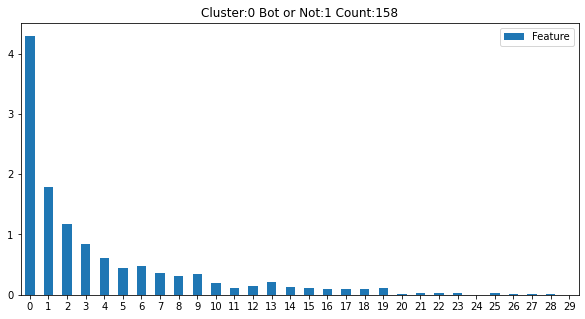

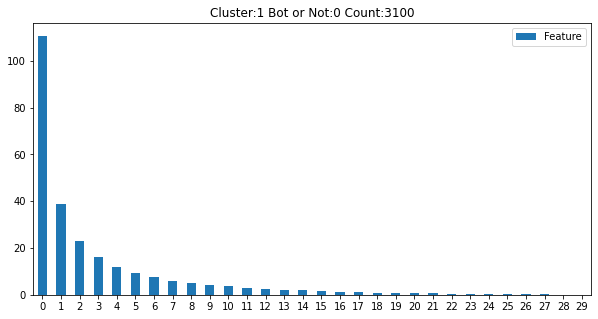

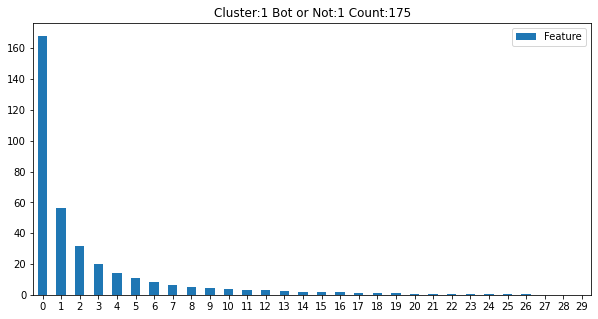

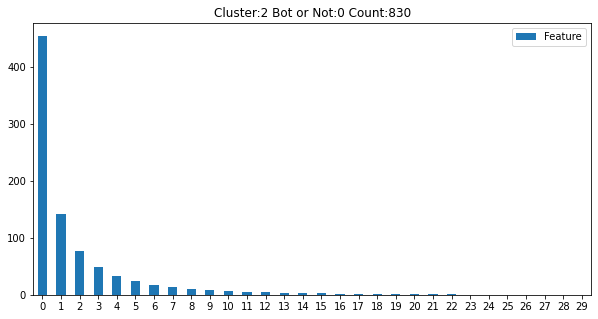

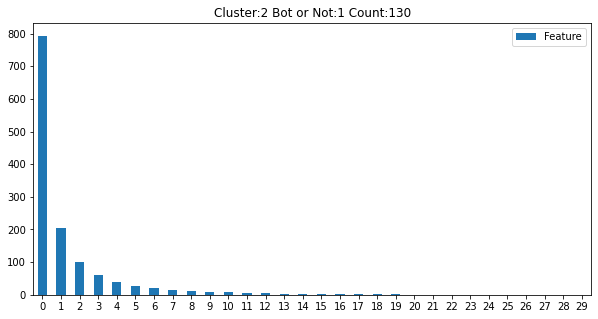

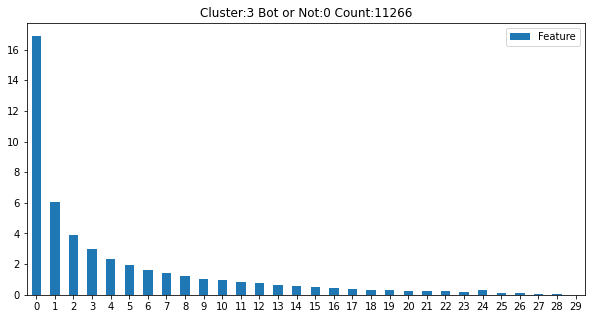

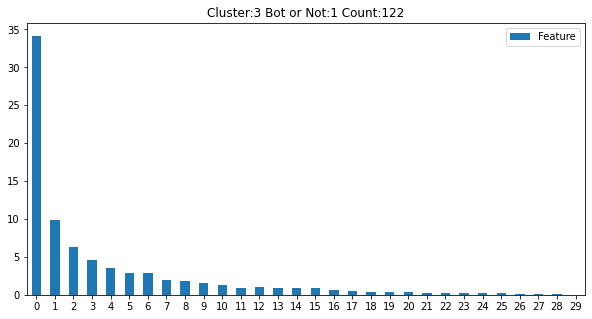

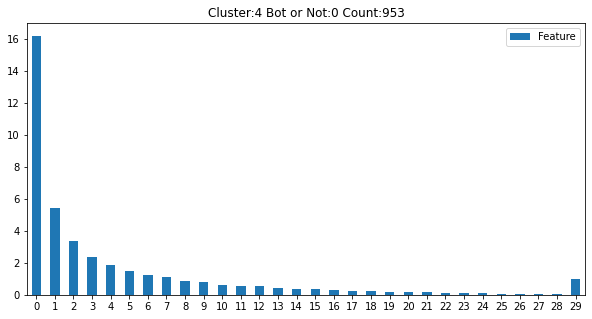

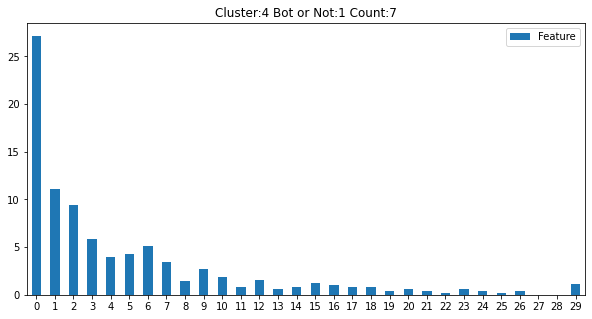

In [0]:
plot_cluster_membership(users,features_np,clustering,botnames_list,no_of_clusters=5 )

# Run TSNE Visualisation

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 268435 samples in 126.785s...
[t-SNE] Computed neighbors for 268435 samples in 2810.614s...
[t-SNE] Computed conditional probabilities for sample 1000 / 268435
[t-SNE] Computed conditional probabilities for sample 2000 / 268435
[t-SNE] Computed conditional probabilities for sample 3000 / 268435
[t-SNE] Computed conditional probabilities for sample 4000 / 268435
[t-SNE] Computed conditional probabilities for sample 5000 / 268435
[t-SNE] Computed conditional probabilities for sample 6000 / 268435
[t-SNE] Computed conditional probabilities for sample 7000 / 268435
[t-SNE] Computed conditional probabilities for sample 8000 / 268435
[t-SNE] Computed conditional probabilities for sample 9000 / 268435
[t-SNE] Computed conditional probabilities for sample 10000 / 268435
[t-SNE] Computed conditional probabilities for sample 11000 / 268435
[t-SNE] Computed conditional probabilities for sample 12000 / 268435
[t-SNE] Computed conditional p

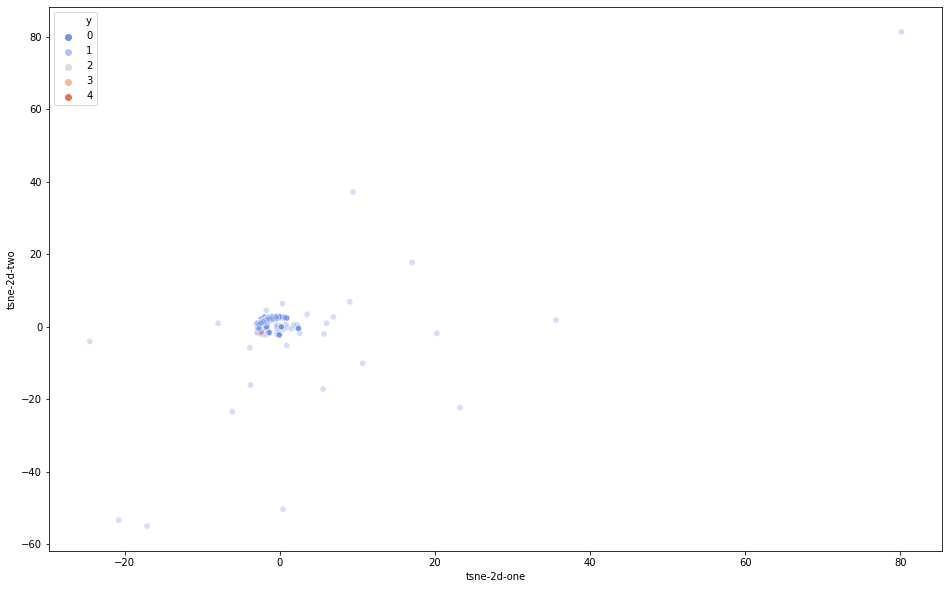

In [0]:
 
tsne_results = plotTSNE(features_np)
scatterPlotTSNE(tsne_results, clustering.labels_)